# Time Series Prediction With Deep Learning

In [125]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense

In [118]:
# load the dataset
dataframe = pd.read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

## ARIMA

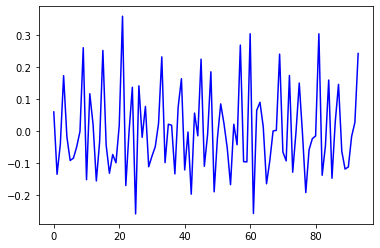

Test Statistic                -1.129496e+01
p-value                        1.350816e-20
#Lags Used                     1.100000e+01
Number of Observations Used    8.200000e+01
Critical Value (1%)           -3.512738e+00
Critical Value (5%)           -2.897490e+00
Critical Value (10%)          -2.585949e+00
dtype: float64


In [119]:
from statsmodels.tsa.stattools import adfuller 

train_log = np.log(train)
train_log_diff = train_log[:-1] - train_log[1:]
train_log_diff2 = train_log_diff[:-1] - train_log_diff[1:]

plt.plot(train_log_diff2, color='blue')
plt.show()

# Perform Dickey-Fuller test:
dftest = adfuller(train_log_diff2, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

The series is stationary and $d=1$ and $s=1$

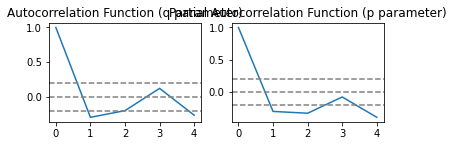

In [120]:
from statsmodels.tsa.stattools import acf, pacf 

lag_acf = acf(train_log_diff2, nlags=20, fft=False) 
lag_pacf = pacf(train_log_diff2, nlags=20, method='ols')

# ACF and PACF plot
plt.subplot(2,2,1)
plt.plot(lag_acf[:5]) 
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff2)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff2)),linestyle='--',color='gray')
plt.title('Autocorrelation Function (q parameter)') 

plt.subplot(2,2,2)
plt.plot(lag_pacf[:5]) 
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff2)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff2)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function (p parameter)') 
plt.show()

According to ACF and PACF plot, q=0 and p=0

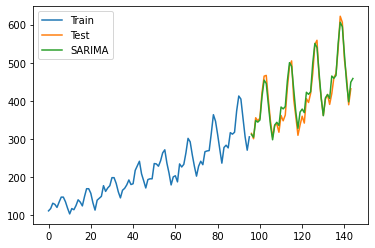

In [121]:
import statsmodels.api as sm

y_hat = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train_log, order=(0, 1, 0), seasonal_order=(0,1,0,12)).fit()
y_hat = np.exp(fit1.predict(start=train_size,end=len(dataset)))

plt.plot(train, label='Train')
plt.plot(np.arange(train_size,len(dataset)),test, label='Test')
plt.plot(np.arange(train_size,len(dataset)+1),y_hat, label='SARIMA')
plt.legend(loc='best')
plt.show();

## Multilayer Perceptron Regression

Now we define a function to create a new dataset as described above. The function takes two arguments, the dataset which is a $\texttt{NumPy}$ array that we want to convert into a dataset and the $\texttt{look_back}$ which is the number of previous time steps to use as input variables to predict the next time period, in this case, defaulted to 1.

This default will create a dataset where $X$ is the number of passengers at a given time $t$ and $Y$ is the number of passengers at the next time $t+1$.


In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [4]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

We use a simple network with 1 input, 1 hidden layer with 8 neurons and an output layer. The model is fit using mean squared error, which if we take the square root gives us an error score in the units of the dataset.

##### Remark: Hyperparameters have to be tuned

In [5]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)

Epoch 1/200
 - 1s - loss: 94160.2568
Epoch 2/200
 - 0s - loss: 71627.9977
Epoch 3/200
 - 0s - loss: 53781.0561
Epoch 4/200
 - 0s - loss: 39527.3332
Epoch 5/200
 - 0s - loss: 28317.6532
Epoch 6/200
 - 0s - loss: 19642.7651
Epoch 7/200
 - 0s - loss: 13161.4237
Epoch 8/200
 - 0s - loss: 8485.2849
Epoch 9/200
 - 0s - loss: 5261.6396
Epoch 10/200
 - 0s - loss: 3210.3087
Epoch 11/200
 - 0s - loss: 1946.2120
Epoch 12/200
 - 0s - loss: 1271.8779
Epoch 13/200
 - 0s - loss: 904.2688
Epoch 14/200
 - 0s - loss: 708.2227
Epoch 15/200
 - 0s - loss: 615.6348
Epoch 16/200
 - 0s - loss: 569.8998
Epoch 17/200
 - 0s - loss: 550.8673
Epoch 18/200
 - 0s - loss: 544.9355
Epoch 19/200
 - 0s - loss: 537.5348
Epoch 20/200
 - 0s - loss: 535.7909
Epoch 21/200
 - 0s - loss: 536.0225
Epoch 22/200
 - 0s - loss: 535.2711
Epoch 23/200
 - 0s - loss: 536.7290
Epoch 24/200
 - 0s - loss: 537.4554
Epoch 25/200
 - 0s - loss: 536.8223
Epoch 26/200
 - 0s - loss: 538.8200
Epoch 27/200
 - 0s - loss: 536.6600
Epoch 28/200
 - 0s

In [6]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

Train Score: 530.37 MSE (23.03 RMSE)
Test Score: 2350.69 MSE (48.48 RMSE)


We can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.

Because of how the dataset was prepared, we must shift the predictions so that they aline on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the train dataset in orange the predictions on the unseen test dataset in red.

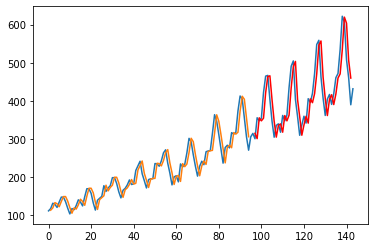

In [7]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot,'r')
plt.show()

### Multilayer Perceptron Regression Using the Window Method

We can also phrase the problem so that multiple recent time steps can be used to make the prediction for the next time step. This is called the window method, and the size of the window is a parameter that can be tuned for each problem.

For example, given the current time $t$ we want to predict the value at the next time in the sequence $t+1$, we can use the current time $t$ as well as the two prior times $t-1$ and $t-2$. When phrased as a regression problem the input variables are $t-2$, $t-1$, $t$ and the output variable is $t+1$.

We can re-run the example in the previous section with the larger window size. We will increase the network capacity to handle the additional information. The first hidden layer is increased to 14 neurons and a second hidden layer is added with 8 neurons. The number of epochs is also increased to 300.

In [7]:
# reshape dataset
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(14, input_dim=look_back, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=400, batch_size=2, verbose=2)

Epoch 1/300
 - 1s - loss: 24538.5849
Epoch 2/300
 - 0s - loss: 7871.6342
Epoch 3/300
 - 0s - loss: 1418.8626
Epoch 4/300
 - 0s - loss: 674.9959
Epoch 5/300
 - 0s - loss: 636.9723
Epoch 6/300
 - 0s - loss: 634.4564
Epoch 7/300
 - 0s - loss: 611.7422
Epoch 8/300
 - 0s - loss: 614.1221
Epoch 9/300
 - 0s - loss: 615.2547
Epoch 10/300
 - 0s - loss: 593.5671
Epoch 11/300
 - 0s - loss: 595.3099
Epoch 12/300
 - 0s - loss: 601.4154
Epoch 13/300
 - 0s - loss: 587.0410
Epoch 14/300
 - 0s - loss: 573.0880
Epoch 15/300
 - 0s - loss: 574.6278
Epoch 16/300
 - 0s - loss: 575.6275
Epoch 17/300
 - 0s - loss: 565.2755
Epoch 18/300
 - 0s - loss: 580.7711
Epoch 19/300
 - 0s - loss: 569.7003
Epoch 20/300
 - 0s - loss: 554.0596
Epoch 21/300
 - 0s - loss: 575.1834
Epoch 22/300
 - 0s - loss: 551.1444
Epoch 23/300
 - 0s - loss: 567.1074
Epoch 24/300
 - 0s - loss: 554.8783
Epoch 25/300
 - 0s - loss: 561.1170
Epoch 26/300
 - 0s - loss: 532.6283
Epoch 27/300
 - 0s - loss: 541.4297
Epoch 28/300
 - 0s - loss: 537.12

 - 0s - loss: 477.6628
Epoch 226/300
 - 0s - loss: 464.1722
Epoch 227/300
 - 0s - loss: 478.0913
Epoch 228/300
 - 0s - loss: 467.4472
Epoch 229/300
 - 0s - loss: 480.6197
Epoch 230/300
 - 0s - loss: 479.7142
Epoch 231/300
 - 0s - loss: 495.9728
Epoch 232/300
 - 0s - loss: 488.2673
Epoch 233/300
 - 0s - loss: 469.9833
Epoch 234/300
 - 0s - loss: 474.6147
Epoch 235/300
 - 0s - loss: 496.2766
Epoch 236/300
 - 0s - loss: 460.7114
Epoch 237/300
 - 0s - loss: 479.1438
Epoch 238/300
 - 0s - loss: 456.2465
Epoch 239/300
 - 0s - loss: 488.5304
Epoch 240/300
 - 0s - loss: 460.4633
Epoch 241/300
 - 0s - loss: 451.2611
Epoch 242/300
 - 0s - loss: 483.2699
Epoch 243/300
 - 0s - loss: 461.3259
Epoch 244/300
 - 0s - loss: 486.8547
Epoch 245/300
 - 0s - loss: 458.3178
Epoch 246/300
 - 0s - loss: 461.0923
Epoch 247/300
 - 0s - loss: 462.5948
Epoch 248/300
 - 0s - loss: 466.5720
Epoch 249/300
 - 0s - loss: 454.5909
Epoch 250/300
 - 0s - loss: 465.1411
Epoch 251/300
 - 0s - loss: 471.2948
Epoch 252/300
 

In [ ]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

In [ ]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()